# Bayesian Networks - thinking about causality in ML

## Motivation
**Key decisions require explanatory models**
* Which medication will help a given patient?
* What marketing campaign will be most effective?
* How can a pharmaceutical company reduce non-conformities during their drug manufacturing process?
* What changes can a vehicle manufacturer make to their new product development process to reduce lead time?
* How can an company deploy resources to better serve customers?

**...and we’d expect explanatory models to make causal sense before trusting a model**

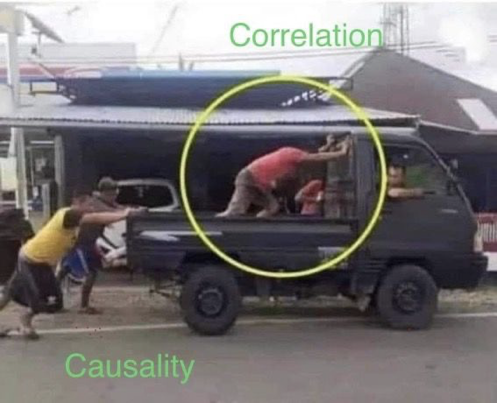


**We can better identify the right intervention with graphical models**

* Traditional models, like linear regressions, have simplistic assumptions
* We use graph models such as Bayesian Networks which can be more intuitive and allows domain expertise encoded with data to form a better understanding of relationships

*E.g., consider a simple example of 4 variables and a disease that varies by age and sun exposure. How these factors relate in a linear regression v. a Bayesian Network:*

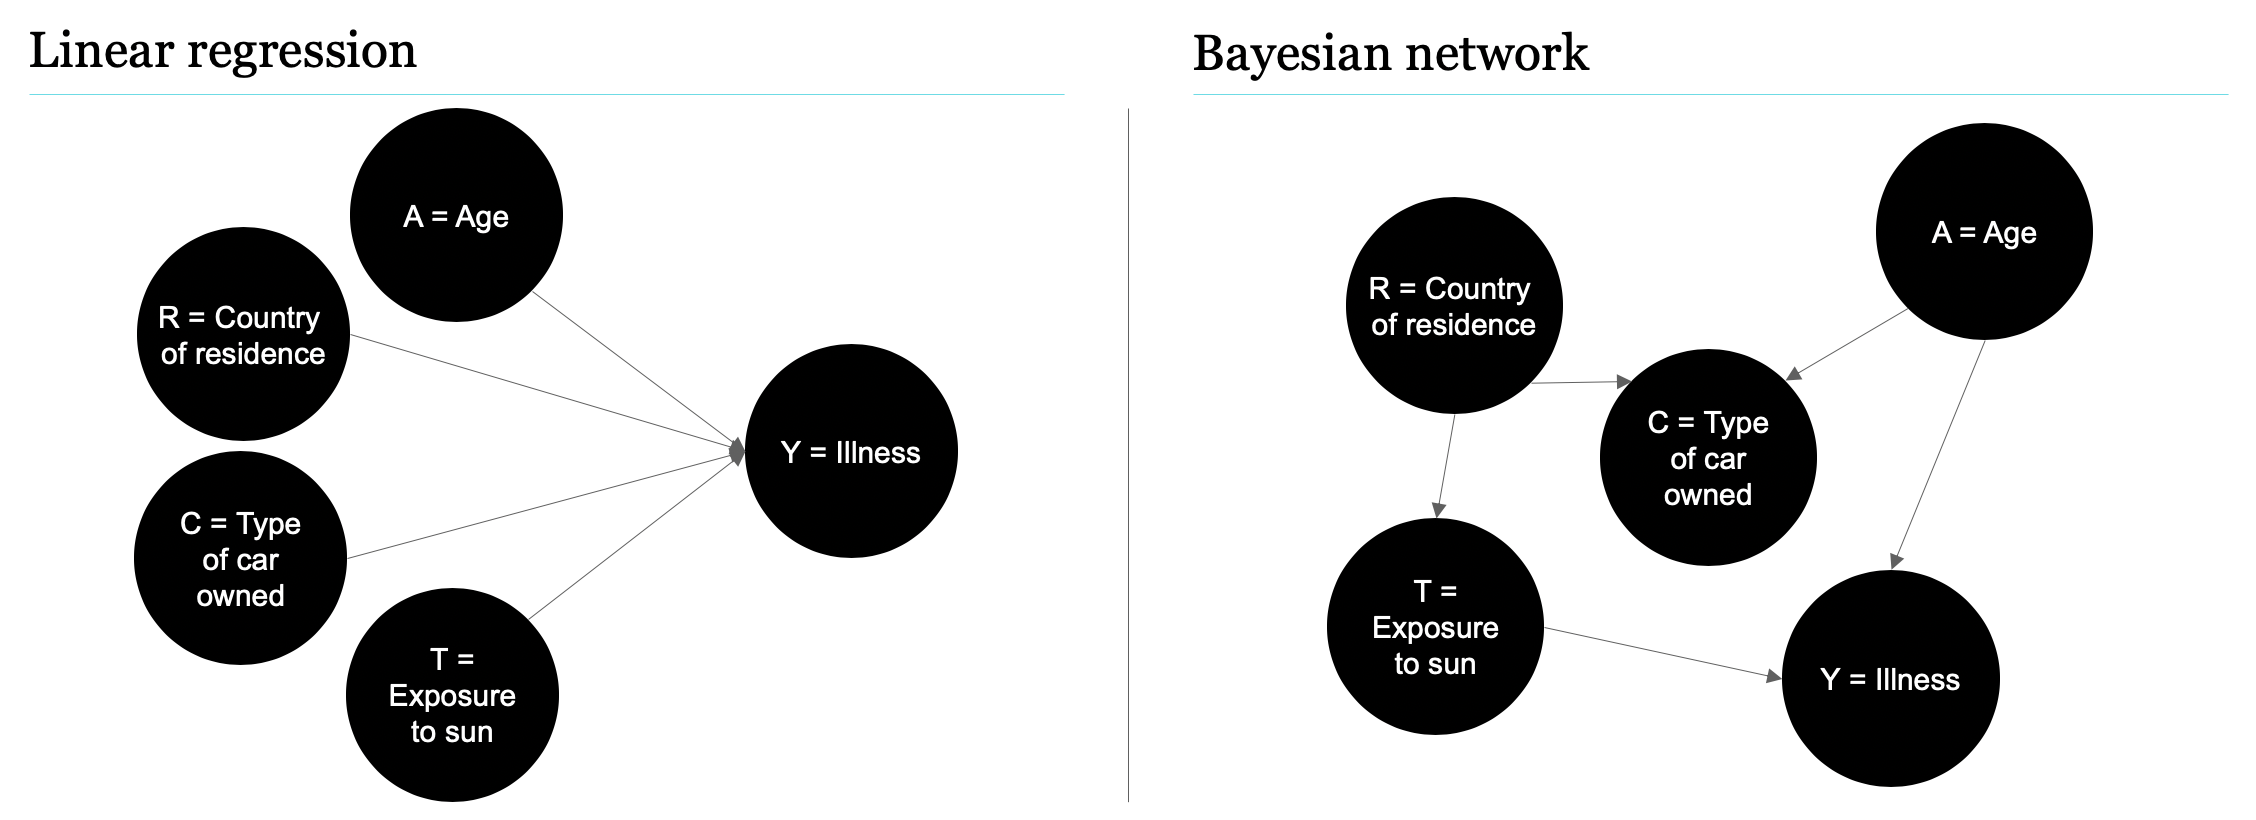

## Bayesian Networks

* Use a directed acyclic graph to capture interdependencies between variables
* Nodes represent variables 
* Edges represent relationships between variables 
* i.e. A --> B means “B depends on A”, or more precisely, “The value of a node is independent of the rest of the variables in the graph given its parents”


**Causal models can then be used to support decision making in important domains such as healthcare...**

*e.g.*

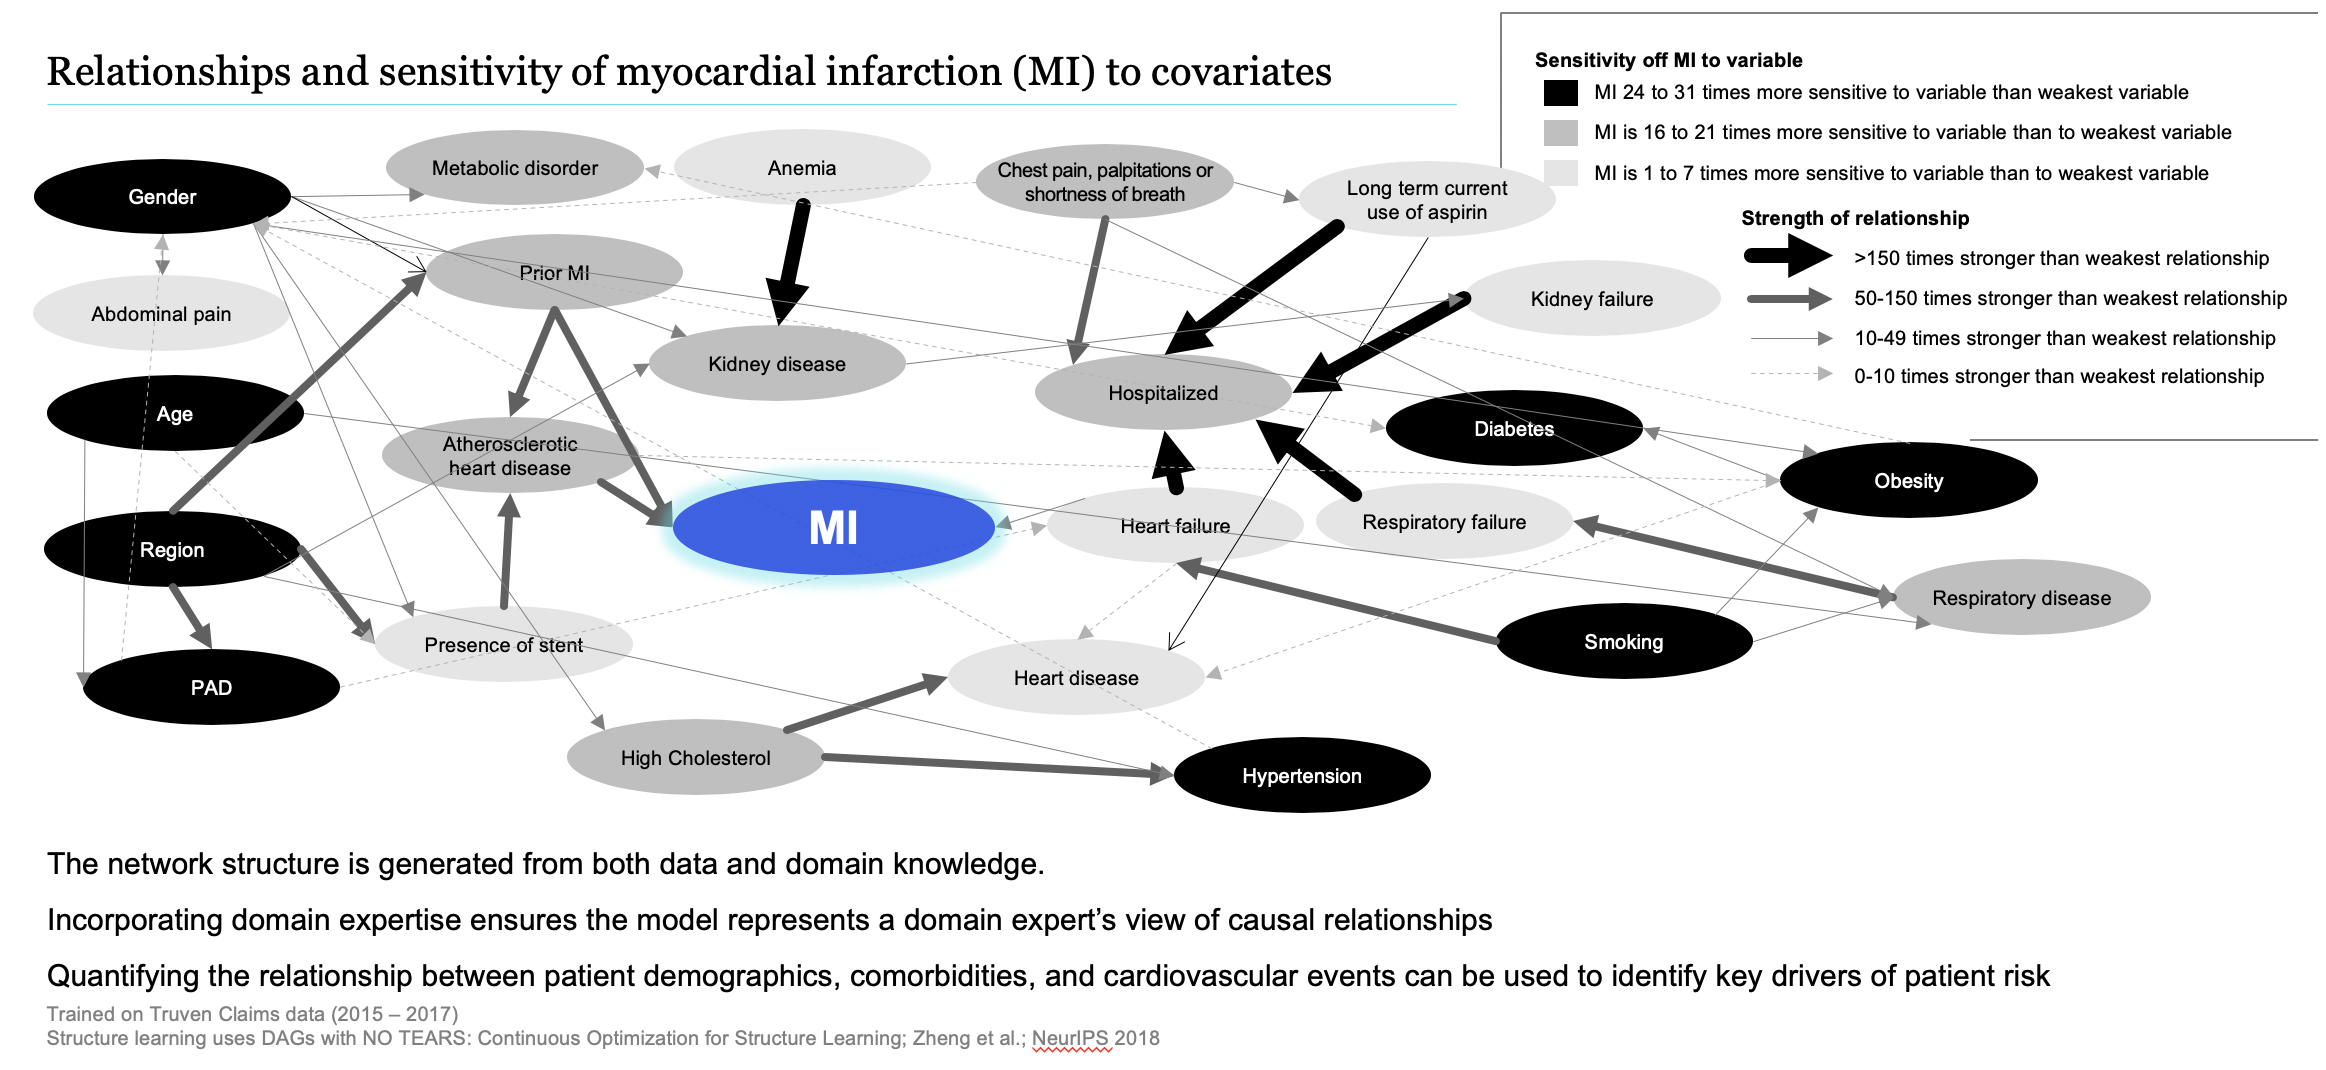


## There are 3 steps: structure learning, probability fitting, inference

* First we must learn the graph: this is a hybrid between data & domain knowledge
* Second, we fit the probabilities and assess the performance of the model
* Third, we can do inference from the model

## Data
This tutorial will walk you through an example workflow using CausalNex to estimate whether a student will pass or fail an exam, by looking at various influences like school support, relationship between family members, and others. We will use the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) published in the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml).


To work through this tutorial, you will need to have the [student.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip) file and extract `student-por.csv` from the zip file into the same directory. If cloning this notebook from McK-Internal, this file is included in the repo.

## Setting up

### Import dependencies

Let's try import everything we're going to need... 
Use the cell after if needs be to do the installs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from IPython.display import Markdown, display

from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

import networkx as nx

def printmd(string):
    display(Markdown(string))

In [2]:
# # Only use these if missing packages
# !pip install -r requirements.txt
# # Install pygraphviz separately if on anaconda and pip fails
# !conda install pygraphviz

In [3]:
# # Can turn off plotting warnings once seen/understand ensuring NOTEARs converges
# import warnings
# warnings.filterwarnings("ignore")

### Load Dataset


In [4]:
data = pd.read_csv('student-por.csv', delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Part I: Structure learning
The structure learning algorithm we are going to use here is the NOTEARS algorithm.

### Why NOTEARS algorithm over other structure learning methods?
Historically, structure learning has been a very hard problem. As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We are interested in looking for the optimal directed acyclic graph (DAGs) that describes the conditional dependencies between variables. However, the search space for this is combinatorial and scales super-exponentially with the number of nodes. NOTEARS algorithm cleverly introduces a new optimisation heuristic and approach to solving this problem, where the runtime for this is no longer exponential but scales cubically with the number of nodes.

Refer to the links below for more information
* https://arxiv.org/abs/1803.01422 for DAGs with NOTEARS: Continuous Optimization for Structure Learning (Zheng et al.)

* https://arxiv.org/abs/2002.00498 for DYNOTEARS: Structure Learning from Time-Series Data (QuantumBlack)

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

Looking at the data, we can see that features consist of numeric and non-numeric columns. We can drop sensitive features such as sex that we do not want to include in our model.

In [5]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


Next, we want to make our data numeric, since this is what the NOTEARS expects. We can do this by label encoding non-numeric variables.

In [6]:
struct_data = data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [7]:
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])
    
struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


We can now apply the NOTEARS algorithm to learn the structure.

In [8]:
sm = from_pandas(struct_data)

and visualise the learned StructureModel using the plot function.

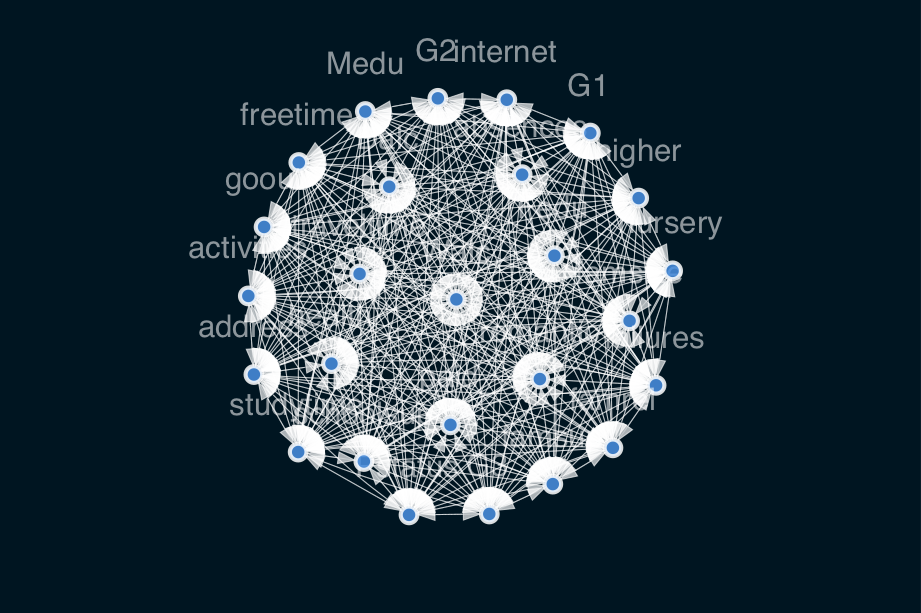

In [9]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

The reason why we have a fully connected graph here is we haven't applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter `w_threshold` in `from_pandas`, or we can remove the edges by calling the structure model function, `remove_edges_below_threshold`.

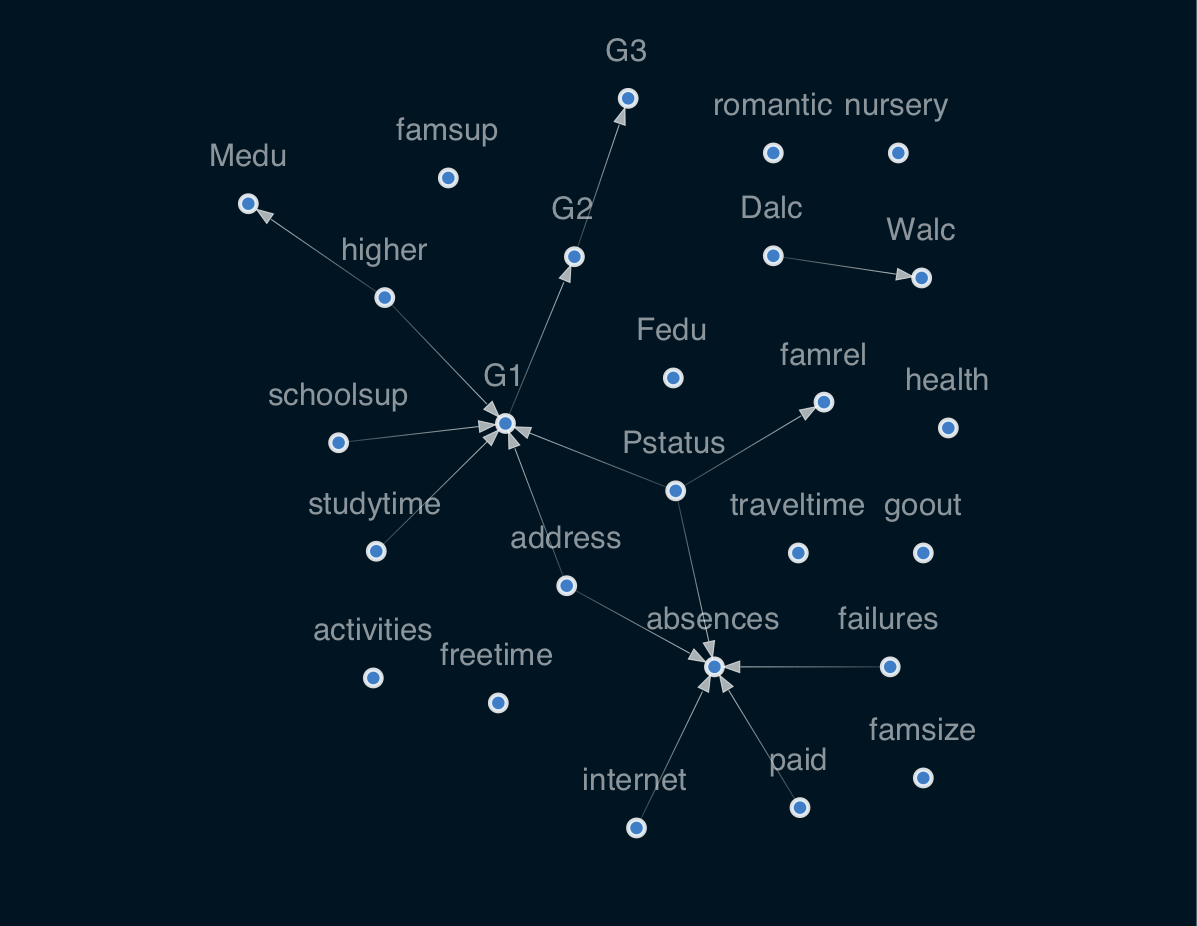

In [10]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In this structure, we can see that there are some relationships that appear intuitively correct:

* `Pstatus` affects `famrel` - if parents live apart, the quality of family relationship may be poor as a result. 
* `internet` affects `absences` - The presence of internet at home may cause student to skip class.
* `studytime` affects `G1` - longer studytime should have a positive impact on a student's result. 

However, there are some relationships that are certainly incorrect:

* `higher` affects `Medu` (Mother's education) - this relationship does not make sense as students who wants to pursue higher education does not affect mother's education. It could be the other way round.

To avoid these erroneous relationships, we can re-run structure learning with some added constraints, or manually add/remove edges incorporating domain knowledge


**Some other issues/tips:** 

1) Structure learning takes a long time to run (can adjust a little by changing how much data is passed - GPU implementations available for larger data in general) -> Potential solution: Use a smaller size random sample

2) Structural learning solution doesn't coverge -> Potential solution: Discretise continuous features to improve convergence of algorithm.

3) There are far too many edges -> Potential solution: Adjust the w threshold to remove edges that don't have a significant importance


In [11]:
sm = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

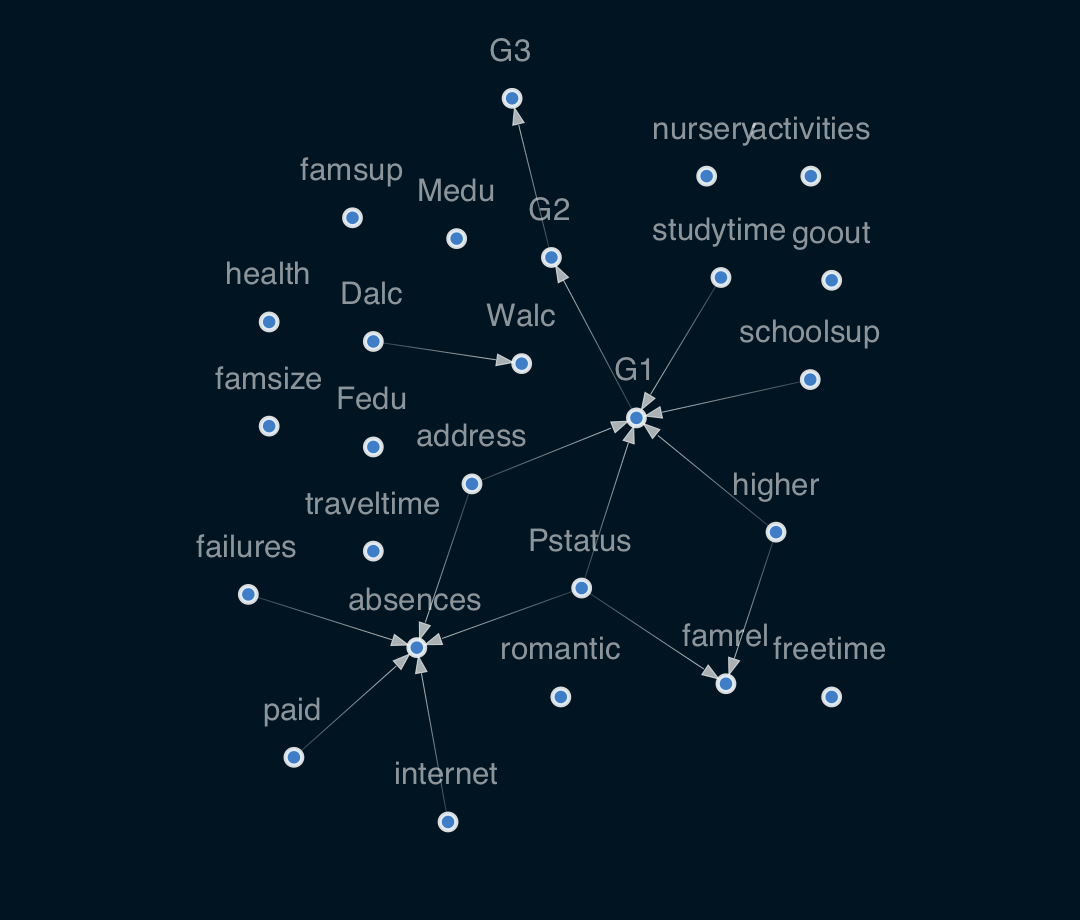

In [12]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

Structure learning algorithms make a best guess at direction – don’t expect them to be correct. To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. 

**Always get experts to review the structure**

Domain knowledge prior to structure learning

* Constrain search space via tabu / required edges

Domain knowledge after structure learning
* Add / remove / flip edges

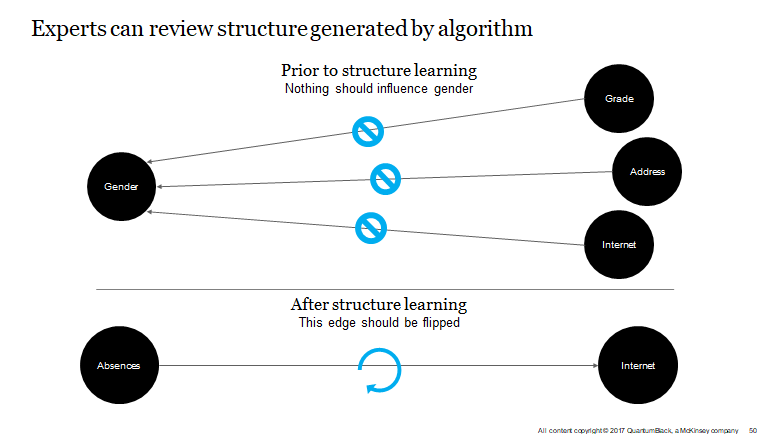

For example, we can add and remove edges as:

In [13]:
sm.add_edge("failures", "G1")
sm.remove_edge("Pstatus", "G1")
sm.remove_edge("address", "G1")

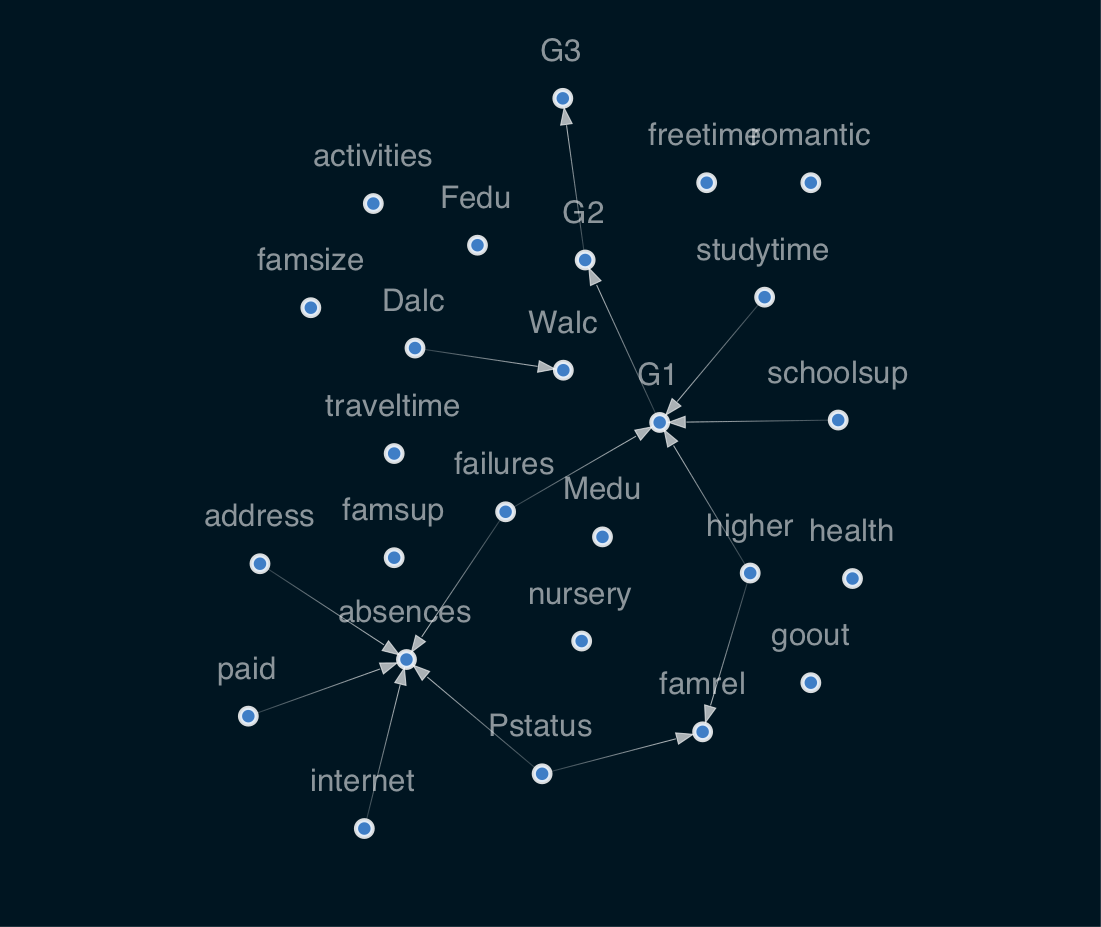

In [14]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

We can see there are two separate subgraphs here in the visualisation plot: `Dalc->Walc` and the other big subgraph. We can retrieve the largest subgraph easily by calling the StructureModel function `get_largest_subgraph()`.

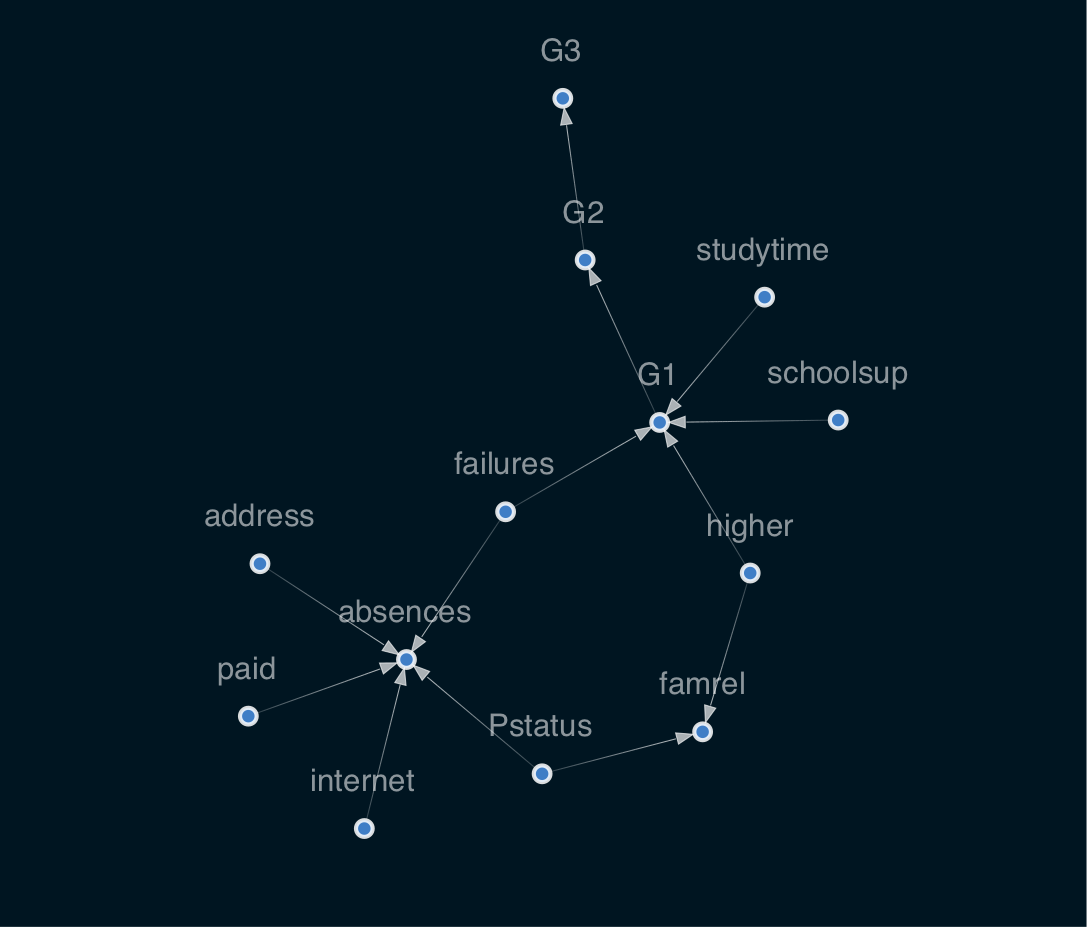

In [15]:
sm = sm.get_largest_subgraph()

viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

This will be a highly iterative process... some other considerations:

* Are there better solutions to get the algorithm to converge other than discretisation?
* Do we need to change the direction of any edges to make causal sense?
* Are there sensitive attributes that should be removed?

The Bayesian network requires a directed acyclic graph for modeling. It's important to check if our structure is acyclic before moving to the next step

In [16]:
# Check acylic
if not nx.is_directed_acyclic_graph(sm):
    cycle = nx.find_cycle(sm)
    raise ValueError(
        "The given structure is not acyclic. Please review the following cycle: {cycle}".format(cycle=cycle))

*Questions!*

Let's explore the sensitivity of the structure learned to:
- the discretisation
- the parameters of the NOTEARS algorithm

Can you explore different configurations and find different results? How do we validate our results anyway? Can you set this up as a "parameter tuning" problem?

After deciding on how the final structure model should look, we can instantiate a `BayesianNetwork`.

In [17]:
bn = BayesianNetwork(sm)

We are now ready to move on to learning the conditional probability distribution of different features in the `BayesianNetwork`.

## Part 2: Probability Fitting

Bayesian Networks in CausalNex support only discrete distributions. Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. Models containing variables with many possible values will typically be badly fit, and exhibit poor performance.

For example, consider P(G2 | G1), where G1 and G2 have possible values 0 to 20. The discrete conditional probability distribution is therefore specified using 21x21 (441) possible combinations - most of which we will be unlikely to observe.

CausalNex provides a few helper methods to make discretisation easier. Let's start by reducing the number of categories in some of the categorical features by combining similar values. We will make numeric features categorical by discretisation, and then give the buckets meaningful labels.

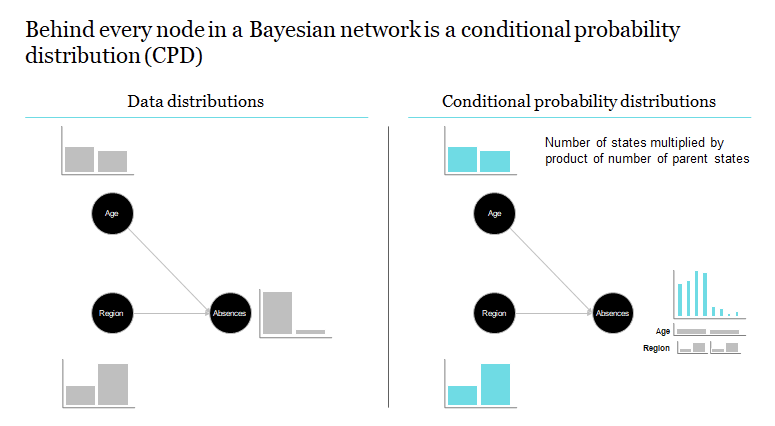

To reduce the cardinality of categorical features we can define a map `{old_value: new_value}`, and use this to update the feature. For example, in the `studytime` feature, we make the studytime which is more than 2 (2 means 2 to 5 hours here, see https://archive.ics.uci.edu/ml/datasets/Student+Performance) into `long-studytime`, and the rest into `short-studytime`.

In [18]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
            else 'have-failure' for v in data_vals['failures']}

studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

Once we have defined our maps `{old_value: new_value}` we can update each feature, applying the mapping transformation.

In [19]:
discretised_data["failures"] = discretised_data["failures"].map(failures_map)
discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

### Discretising Numeric Features

To make numeric features categorical, they must first be discretised. CausalNex provides a helper class `causalnex.discretiser.Discretiser`, which supports several discretisation methods. For our data the `fixed` method will be applied, providing static values that define the bucket boundaries. For example, `absences` will be discretised into the buckets < 1, 1 to 9, and >=10. Each bucket will be labelled as an integer from zero.

Benefits of discretization
1. Allows for data that are not normally distributed
2. Flexible granularity, with continuous data bucketed as appropriate
3. Discrete or categorical data can also be grouped if no significant difference between classes

There are several approaches to perform discretization


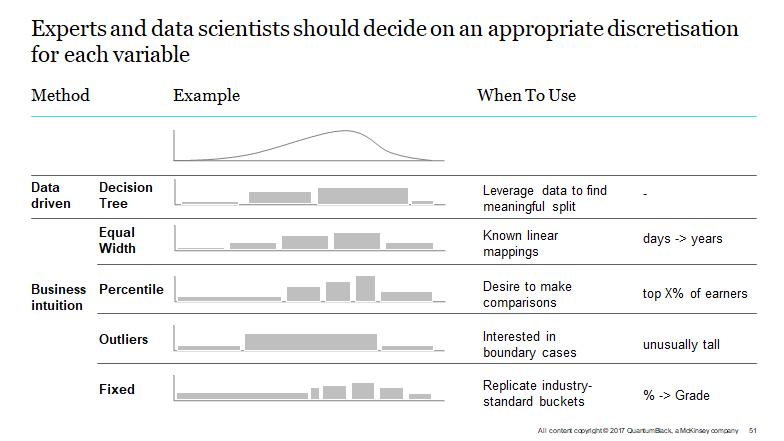


In [20]:
from causalnex.discretiser import Discretiser

discretised_data["absences"] = Discretiser(method="fixed", 
                          numeric_split_points=[1, 10]).transform(discretised_data["absences"].values)

discretised_data["G1"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G1"].values)

discretised_data["G2"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G2"].values)

discretised_data["G3"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G3"].values)

To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [21]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [22]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [23]:
bn = bn.fit_node_states(discretised_data)

The `fit_cpds` method of `BayesianNetwork` accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [24]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

Once we have the CPDs, we can inspect them through the `cpds` property, which is a dictionary of node->cpd.

In [25]:
bn.cpds["G1"]

failures    have-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75        0.806452            0.5            0.75   
Pass                0.25        0.193548            0.5            0.25   

failures                                                                 \
higher               yes                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612245            0.5            0.75   
Pass                 0.5        0.387755            0.5            0.25   

failures      no-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612903            0.5             0.5   
Pass                 0.5        0.387097            0.5             0.5   

failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail            0.032967         0.15016       0.111111        0.255814  
Pass            0.967033         0.84984       0.888889        0.744186

The CPD dictionaries are multi-indexed, and so the `loc` function can be a useful way to interact with them.

### Predict the State given the Input Data

The `predict` method of `BayesianNetwork` allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a student fails or passes their exam based on the input data. Imagine we have an incoming student data that looks like this:

In [26]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

### Performance Evaluation

To evaluate the quality of the model that has been learned, CausalNex supports two main approaches: Classification Report and Receiver Operating Characteristics (ROC) / Area Under the ROC Curve (AUC). In this section each will be discussed.

In [27]:
# Assess the performance of the 'target' node
pd.DataFrame(classification_report(bn, test, "G1"))

,G1_Fail,G1_Pass,accuracy,macro avg,weighted avg
precision,0.777778,0.910714,0.892308,0.844246,0.886172
recall,0.583333,0.962264,0.892308,0.772799,0.892308
f1-score,0.666667,0.935780,0.892308,0.801223,0.886097
support,12.000000,53.000000,0.892308,65.000000,65.000000


This report shows that the model we have defined is able to classify whether a student passes their exam reasonably well.

For the predictions where the student fails, the precision is good, but recall is bad. This implies that we can rely on predictions for this class when they are made, but we are likely to miss some of the predictions we should have made. Perhaps these missing predictions are as a result of something missing in our structure - this could be an interesting area to explore.

Receiver Operating Characteristics (ROC), and the Area Under the ROC Curve (AUC) can be obtained using the `roc_auc` method within the CausalNex metrics module. Again, a test set and target node must be provided. The ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [28]:
roc, auc = roc_auc(bn, test, "G1")
print(auc)

0.9181065088757396


The AUC value for our model is high, giving us confidence in the performance.

*Questions!*

How can we improve the performance?
What happens when we don't have enough data to cover all options? When will this get worse? How can we try/help solve for this?

## Part III: Inference & interventions
After iterating over our model structure, CPDs, and validating our model quality, we can query our model under different observations to gain insights.

**How can we use Bayesian Networks?**

The probabilities of variables in Bayesian Networks update as observations are added to the model. This is useful for inference, and for beginning predictive analytics



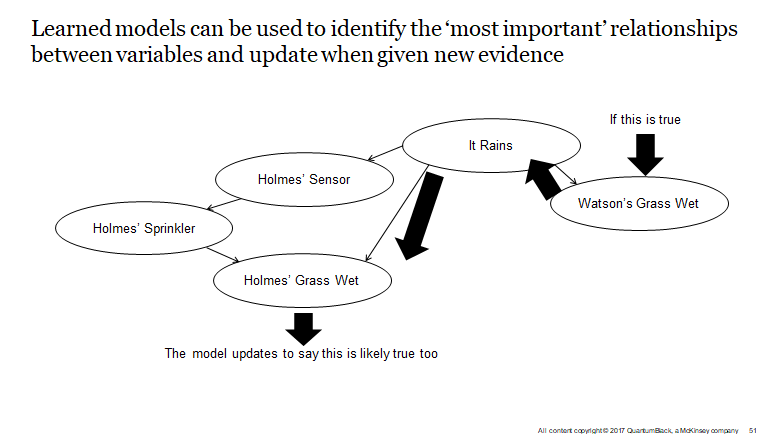



**The differences between observational and interventional inference can be best viewed through SCM notation**

<div>
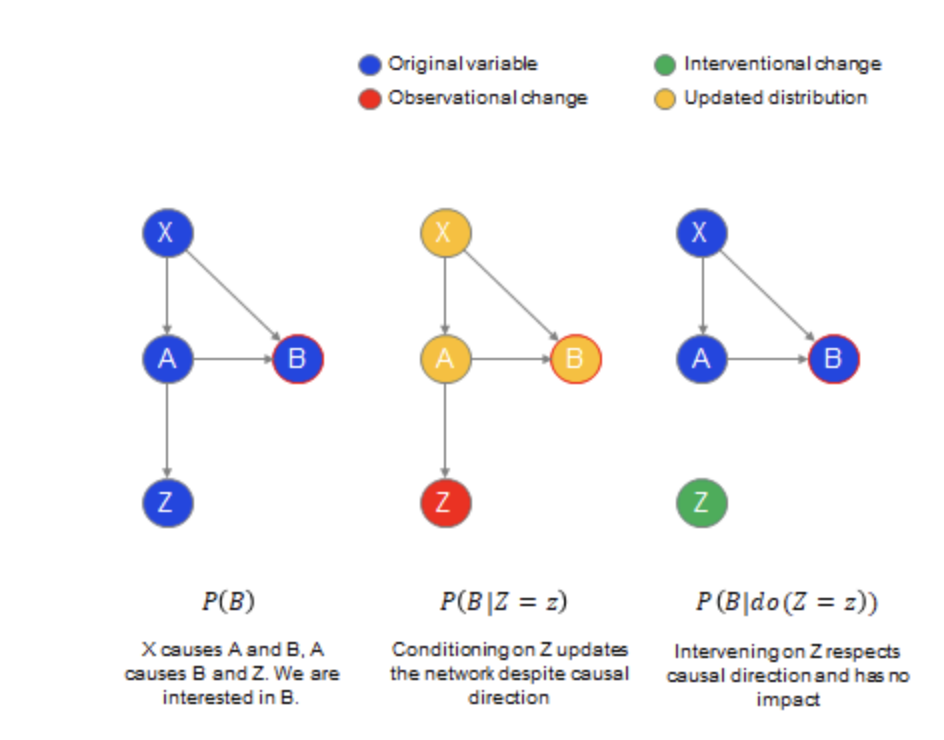
    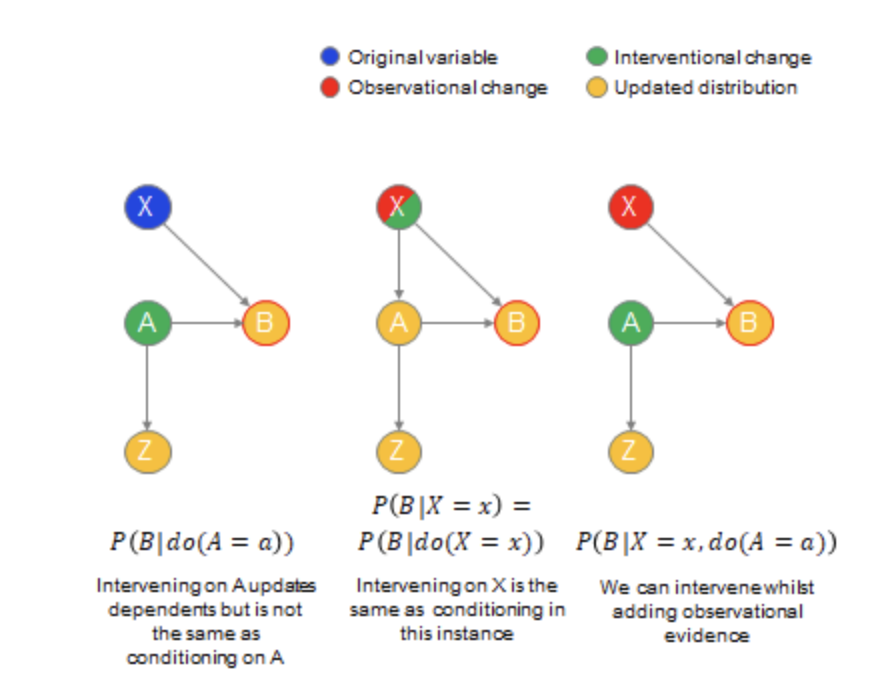
</div>


Observing evidence asks the model to update likelihoods of variables throughout the model based on an observation.

* If Z is observed to have a specific value, what can we infer about the likely values A, B and X had at this point? The distributions of A, B and X all update given this observational information.

* If we intervene on Z, the causal direction states that A (nor any other nodes) are impacted, and we “break” the link between A and Z. Distributions of A, B and X (in this instance) remain unchanged, because Z does not “cause” any of them, and so intervening on Z is folly.

Intervening on A “breaks” its dependence from X (and doesn’t update the distribution of X, unlike conditioning on A). B and Z are both descendents of A, and their marginal probabilities would change due to the change in A.

* For nodes with no parents, intervening on them is identical to receiving observational update.
* We can combine interventions with observational data. For observation in X and intervention on A, B would update to reflect changes in both A and X. A still stops depending on X because of the intervention, and Z updates based only on the intervention change to A, and not due to updates to X.


To query the model for baseline marginals that reflect the population as a whole, a `query` method can be used. First let's update our model using the complete dataset, since the one we currently have was only built from training data.

In [29]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

We can safely ignore these warnings, which let us know we are replacing the previously existing CPDs. 

For inference, we must create a new InferenceEngine from our BayesianNetwork, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes.

In [30]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["G1"] 

{'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}

The output observed tells us that `P(G1=Fail) = 0.25`, and the `P(G1=Pass) = 0.75`. As a quick sanity check, we can compute what proportion of our dataset are `Fail`, which should be approximately the same.

In [31]:
labels, counts = np.unique(discretised_data["G1"], return_counts=True)
list(zip(labels, counts))

[('Fail', 157), ('Pass', 492)]

The proportion of the students who fail is `157 / (157+492) = 0.242` - which is close to our computed marginal likelihood.


### Marginals after Observations

We can also query the marginal likelihood of states in our network given some observations. These observations can be made anywhere in the network, and their impact will be propagated through to the node of interest.

Let's look at the difference in the likelihood of `G1` based on `studytime`.

In [32]:
marginals_short = ie.query({"studytime": "short-studytime"})
marginals_long = ie.query({"studytime": "long-studytime"})
print("Marginal G1 | Short Studtyime", marginals_short["G1"])
print("Marginal G1 | Long Studytime", marginals_long["G1"])

Marginal G1 | Short Studtyime {'Fail': 0.2776556433482524, 'Pass': 0.7223443566517477}
Marginal G1 | Long Studytime {'Fail': 0.15504850337837614, 'Pass': 0.8449514966216239}


Based on our data we can see that students who study longer are more likely to pass their exam.

We can apply an intervention to any node in our data, updating its distribution using a `do` operator. This can be thought of as asking our model "What if" something were different. For example, we could ask what would happen if 100% of students wanted to go on to do higher education.

In [33]:
print("distribution before do", ie.query()["higher"])
ie.do_intervention("higher", 
                   {'yes': 1.0, 
                    'no': 0.0})
print("distribution after do", ie.query()["higher"])

distribution before do {'no': 0.10752688172043011, 'yes': 0.8924731182795698}
distribution after do {'no': 0.0, 'yes': 0.9999999999999998}


We can reset any interventions that we make by using the `reset_intervention` method, and providing the node that we want to reset.

In [34]:
ie.reset_do("higher")

We can again use `query` to examine the effect that an intervention has on our marginal likelihoods. In this case, we can look at how the likelihood of achieving a pass changes if 100% of students wanted to do higher education.

In [35]:
print("marginal G1", ie.query()["G1"])
ie.do_intervention("higher", 
                   {'yes': 1.0, 
                    'no': 0.0})
print("updated marginal G1", ie.query()["G1"])

marginal G1 {'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}
updated marginal G1 {'Fail': 0.20682952942551894, 'Pass': 0.7931704705744809}


In this case, we can see that if 100% of students wanted to do higher education (as opposed to 90% in our data population), then we estimate that pass rate would increase from 74.7% to 79.3%.

*Questions!*

Can you think of how we might find the "optimal" intervention to make?